# Y3 Gold classification plots

This notebook is intended to be used to create Y3 Gold paper plots: classification

In [1]:
%matplotlib inline
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import kde
#import fitsio
from astropy.io import fits
from astropy.io.fits.hdu.hdulist import HDUList
import healpy as hp
from descolors import BAND_COLORS
import warnings
warnings.filterwarnings('ignore')
workdir = '/Users/nsevilla/y3gold-paper/'
datadir = '/Volumes/NO NAME/'
figsdir = '/Users/nsevilla/y3gold-paper/figs/'

ImportError: No module named 'descolors'

In [2]:
#load Alex's skymap utilities
import skymap
from skymap import Skymap,McBrydeSkymap,OrthoSkymap
from skymap import SurveySkymap,SurveyMcBryde,SurveyOrtho
from skymap import DESSkymap

SKYMAPS = [Skymap,McBrydeSkymap,OrthoSkymap]
SURVEYS = [SurveySkymap,SurveyMcBryde,SurveyOrtho]

NSIDE = 4096
NSIDE_deg = 512

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3

In [4]:
import scipy.optimize
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2./(2.*sigma**2))

### Stellar map and histogram

In [1]:
# we will use the samples downloaded from the DB
# select hpix_4096 as PIXEL, count(*) as SIGNAL from Y3_GOLD_2_2 where flags_footprint = 1 
# and extended_class_mash_sof = 0 (1,2,3) and sof_psf_mag_r BETWEEN 16 AND 23 group by hpix_4096; 
# > /data1/des/y3_validation/stars_sof0_16_23.fits

In [11]:
Y3_star_map = fits.open(datadir+'stars_sof3_16_23.fits',memmap=True)
Y3_star_data = Y3_star_map[1].data

/anaconda2/envs/skymap/lib/python3.6/site-packages/ipykernel/__main__.py:1: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/NO NAME/stars_sof0_16_23.fits' mode='rb' closefd=True>
  if __name__ == '__main__':


In [12]:
Y3_star_data_fullsky_nest_4096 = np.full(hp.nside2npix(NSIDE),hp.UNSEEN)

In [13]:
Y3_star_data_fullsky_nest_4096[Y3_star_data['PIXEL']] = Y3_star_data['SIGNAL']
Y3_star_data_fullsky_ring_4096 = hp.reorder(Y3_star_data_fullsky_nest_4096,n2r=True)

In [14]:
Y3_star_data_fullsky = hp.ud_grade(Y3_star_data_fullsky_ring_4096,nside_out=NSIDE_deg,power=-2)

In [15]:
pix, = np.where(Y3_star_data_fullsky != hp.UNSEEN)
mask = Y3_star_data_fullsky != hp.UNSEEN
nstars = Y3_star_data_fullsky[mask]
print(pix)

[1412238 1412274 1412275 ... 3033079 3033080 3033081]


/anaconda2/envs/skymap/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4759: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


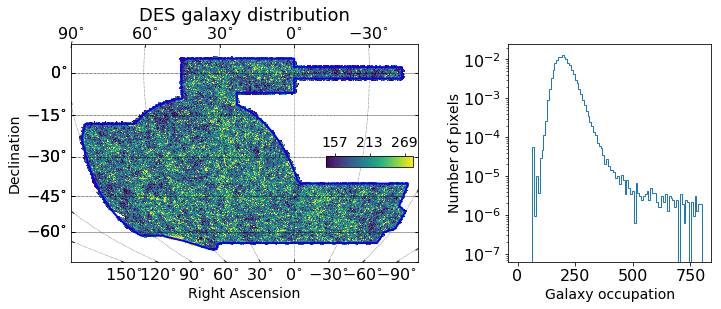

In [17]:
fig = plt.figure(figsize=(12.,4.))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
smap = DESSkymap()  
#smap.draw_hpxmap(nstars.byteswap().newbyteorder(),pix.byteswap().newbyteorder(),NSIDE,xsize=1000)
smap.draw_hpxmap(nstars,pix,NSIDE_deg,xsize=1000)
smap.draw_inset_colorbar(fontsize=14)
smap.draw_des()
plt.title('DES galaxy distribution', fontsize = 18, y=1.08)
ax2 = plt.subplot(gs[1])
fig.add_subplot(ax2)
plt.sca(ax2)
plt.xlabel('Galaxy occupation')
plt.ylabel('Number of pixels',labelpad=1)
n,b,p = plt.hist(nstars,normed=True,histtype='step',bins=100,range=[0,800],log=True)
plt.savefig(figsdir+'y3gold_galaxy_distribution_sof.png')

### Generic distributions

/anaconda2/envs/skymap/lib/python3.6/site-packages/ipykernel/__main__.py:3: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/NO NAME/sample_0.1_y3gold.fits' mode='rb' closefd=True>
  app.launch_new_instance()


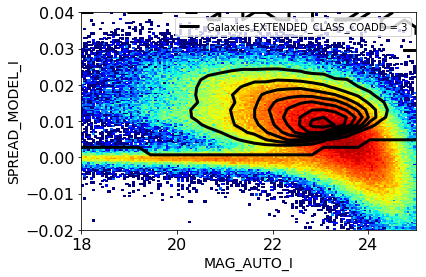

In [26]:
# use a 0.1% sample from gold
Y3_sample = fits.open(datadir+'sample_0.1_y3gold.fits',memmap=True)
Y3_sample = Y3_sample[1].data
nbins= 150
nbins2d = [nbins,nbins]
xmin = 18
xmax = 25
ymin = -0.02
ymax = 0.04
hrange = [[xmin,xmax],[ymin,ymax]]
#mag_string = 'SOF_CM_MAG_I'
#class_string = 'SOF_CM_T'
#classerr_string = 'SOF_CM_T_ERR'
#selection_1 = (Y3_sample['SOF_CM_T'] + 5. * Y3_sample['SOF_CM_T_ERR']) > 0.1
#selection_2 = (Y3_sample['SOF_CM_T'] + 1. * Y3_sample['SOF_CM_T_ERR']) > 0.05
#selection_3 = (Y3_sample['SOF_CM_T'] - 1. * Y3_sample['SOF_CM_T_ERR']) > 0.02
mag_string = 'MAG_AUTO_I'
class_string = 'SPREAD_MODEL_I'
classerr_string = 'SPREADERR_MODEL_I'
selection_1 = (Y3_sample['SPREAD_MODEL_I'] + 3. * Y3_sample['SPREADERR_MODEL_I']) > 0.005
selection_2 = (Y3_sample['SPREAD_MODEL_I'] + 1. * Y3_sample['SPREADERR_MODEL_I']) > 0.003
selection_3 = (Y3_sample['SPREAD_MODEL_I'] - 1. * Y3_sample['SPREADERR_MODEL_I']) > 0.002
gal_selection = selection_1 & selection_2 & selection_3
plt.clf()
plt.xlabel(mag_string)
plt.ylabel(class_string)#+'+2*'+classerr_string)
plt.hist2d(Y3_sample[mag_string],Y3_sample[class_string],
           bins=nbins2d,cmap='jet',norm=matplotlib.colors.LogNorm(),range=hrange)
counts,xbins,ybins = np.histogram2d(Y3_sample[mag_string][gal_selection],
                                    Y3_sample[class_string][gal_selection],
                                    range=hrange,bins=[30,30])#,normed=matplotlib.colors.LogNorm())
#data = [Y3_sample[mag_string][gal_selection],Y3_sample[class_string][gal_selection]+2*Y3_sample[classerr_string][gal_selection]]
#data = np.asarray(data).T
#k = kde.gaussian_kde(data)
#xi, yi = np.mgrid[xmin:xmax:20*1j,ymin:ymax:20*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#plt.contour(xi, yi, zi.reshape(xi.shape))
cntr1 = plt.contour(counts.transpose(),extent=[xmin,xmax,ymin,ymax],
            colors='black',linestyles='solid',levels=7)
h1,_ = cntr1.legend_elements()
plt.legend([h1[0]], ['Galaxies EXTENDED_CLASS_COADD = 3'])
plt.savefig(figsdir+'y3gold_spread_model.png')

In [9]:
import healpy as hp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import matplotlib.image as mpimg
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
plt.rc('font',**{'family':'serif','serif':['DejaVu Sans'], 'size': 12})
mpl.rcParams['legend.numpoints'] = 1
plt.rc('text', usetex=True)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3
cmap = mpl.cm.get_cmap("inferno")
cmap.set_under('darkgray')
cmap.set_bad('darkgray')

In [18]:
def plot_moll_cut(m, ns, label, filename, obj_k, number, vmin, vmax):
    ra_DES, dec_DES = np.loadtxt('data/des-round17-poly.txt', usecols=(0, 1), unpack=True)
    m_ = np.copy(m)
    m_[(m <= vmin)&(m > 0.)] = vmin
    m_[(m >= vmax)] = vmax
    hp.visufunc.mollview(map=m_, flip='geo', format='%.3g', cmap='inferno', coord='C', hold=True, xsize=800,
                         nest=False, cbar=False, notext=True, margins=None)
    hp.projplot(ra_DES, dec_DES, lonlat=True, coord=['C'], zorder=10, color='b', lw=0.5)
    hp.graticule(dpar=15.,dmer=30., lw=0.1)
    plt.savefig('figs/primary.png', dpi=600, bbox_inches='tight', pad_inches=0)
    plt.close()
    plt.clf()
    
    d_op = mpimg.imread('figs/primary.png')
    w, h = len(d_op[0,:]), len(d_op[:,0])
    # d_op = d_op[int(0.08156*h):int(0.9095*h),int(0.082*w):int(0.982*w)]
    d_op = d_op[int(0.125*h):int(0.88*h),int(0.1*w):int(0.99*w)]
    w, h = len(d_op[0,:]), len(d_op[:,0])
    fig = plt.figure(figsize = [15., 7])
    
    gridspec.GridSpec(12,30)
    plt.subplot2grid((12,30), (0,0), colspan=20, rowspan=12)
    #ax1 = fig.add_subplot(111)
    #plt.set_facecolor('lightgray')
    plt.imshow(d_op[int(0.4293*h):int(0.9497*h), int(0.3611*w):int(0.75*w)], extent=[-45., 90.,-75.,10.],
               aspect='auto', origin='upper', interpolation=None, vmin=0., vmax=0.2, cmap=cmap)
    plt.title(r'$\mathrm{%s}$' % label, fontsize=20)
    plt.xlabel(r'$\mathrm{\alpha}$', fontsize=16)
    plt.ylabel(r'$\mathrm{\delta}$', fontsize=16)
    plt.ylim([-75,10])
    plt.xlim([90,-45])

    y_ = [-0., -15, -34, -50, -66, -75]
    labels_y=[r'$\mathrm{0^o}$', r'$\mathrm{-15^o}$', r'$\mathrm{-30^o}$', r'$\mathrm{-45^o}$', r'$\mathrm{-60^o}$', r'$\mathrm{-75^o}$']
    x = [67, 54, 41.5, 29, 16, 3, -9, -22, -35]
    labels=[r'$\mathrm{150^o}$', r'$\mathrm{120^o}$', r'$\mathrm{90^o}$', r'$\mathrm{60^o}$', r'$\mathrm{30^o}$', r'$\mathrm{0^o}$', r'$\mathrm{-30^o}$', r'$\mathrm{-60^o}$', r'$\mathrm{-90^o}$']

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=True)
    plt.xticks(x, labels, rotation='horizontal')
    plt.yticks(y_, labels_y)
    cbaxes = fig.add_axes([0.427, 0.63, 0.2, 0.035])
    cb = plt.colorbar(cax=cbaxes, cmap=cmap, orientation='horizontal', ticks=[np.arange(vmin,vmax,100)]) #, label=r'$\mathrm{%s}$' % labelcb)
    cb.ax.tick_params(labelsize=10)

    plt.subplot2grid((12,30), (0,23), colspan=7, rowspan=12)
    plt.hist(m, bins=np.arange(0,800,10.), color='r', alpha = 0.25, lw=1, histtype='step', log=True, zorder=3)
    n, bins, patches = plt.hist(m, bins=np.arange(0.,800,10.), color='r', alpha = 0.5, lw=1, log=True, zorder=3)
    CA = plt.gca()
    CA.add_patch(Rectangle((vmin, 1.), vmax-vmin, 1.2*n.max(), alpha=0.5, color='b', zorder=1))
    #ar_ = np.linspace(1.,1.3*np.max(n),10)
    #plt.plot(vmin + 0*ar_, ar_, 'k:', lw=0.8)
    #plt.plot(vmax + 0*ar_, ar_, 'k:', lw=0.8)
    plt.xlabel(r'$\mathrm{%s\ ocupation}$' % obj_k)
    plt.xlim([0,800])
    plt.xticks([0,200,400,600,800])
    plt.ylim([1.,1.2*np.max(n)])
    plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.25)
    plt.ylabel(r'$\mathrm{Number\ of\ pixels}$')
    #plt.savefig('figs/HP_EQU_sof' + str(number) +'.png', dpi=300, bbox_inches='tight')
    #plt.close()
    #plt.clf()

In [19]:
def read_map_source(class_number, nside, nside2):
    Y3_star_map = fits.open('data/sources_sof'+str(class_number)+'_16_23.fits',memmap=True)
    Y3_star_data = Y3_star_map[1].data
    #mask = np.zeros(hp.nside2npix(nside), dtype=np.bool)
    #Y3_star_data_fullsky_nest_4096 = np.zeros(hp.nside2npix(nside))
    Y3_star_data_fullsky_nest_4096 = np.full(hp.nside2npix(nside),hp.UNSEEN)
    Y3_star_data_fullsky_nest_4096[Y3_star_data['PIXEL']] = Y3_star_data['SIGNAL']
    Y3_star_data_fullsky_ring_4096 = hp.reorder(Y3_star_data_fullsky_nest_4096,n2r=True)
    Y3_star_data_fullsky = hp.ud_grade(Y3_star_data_fullsky_ring_4096,nside_out=nside2,power=-2)
    pix, = np.where(Y3_star_data_fullsky != hp.UNSEEN)
    mask = Y3_star_data_fullsky != hp.UNSEEN
    #mask[Y3_star_data_fullsky == 0.] = 1
    #m = hp.ma(Y3_star_data_fullsky)
    #m.mask = mask
    #pix = np.where(np.abs(m) < 1)
    nsources = Y3_star_data_fullsky[mask]
    return Y3_star_data_fullsky, nsources

In [ ]:
HPX0, nsources0 = read_map_source(0, 4096, 512)

HPX3, nsources3 = read_map_source(3, 4096, 512)

In [ ]:
plot_moll_cut(HPX0, nsources0, 'DES\ stellar\ distribution', ' ', 'Star', 0, 70., 500)
plot_moll_cut(HPX3, nsources3, 'DES\ galaxy\ distribution', ' ', 'Galaxy', 3, 100, 400)

In [ ]:
from scipy.ndimage.filters import gaussian_filter

def SMhist2d():
    Y3_sample = fits.open('data/y3_v22_gold_milisample.fits',memmap=True)[1].data
    nbins= 100
    nbins2d = [nbins,nbins]
    xmin, xmax, ymin, ymax = 18, 25, -0.02, 0.04
    hrange = [[xmin,xmax],[ymin,ymax]]

    mag_string = 'MAG_AUTO_I'
    class_string = 'SPREAD_MODEL_I'
    classerr_string = 'SPREADERR_MODEL_I'
    selection_1 = (Y3_sample['SPREAD_MODEL_I'] + 3. * Y3_sample['SPREADERR_MODEL_I']) > 0.005
    selection_2 = (Y3_sample['SPREAD_MODEL_I'] + 1. * Y3_sample['SPREADERR_MODEL_I']) > 0.003
    selection_3 = (Y3_sample['SPREAD_MODEL_I'] - 1. * Y3_sample['SPREADERR_MODEL_I']) > 0.002
    gal_selection = selection_1 & selection_2 & selection_3
    star_selection = (selection_1 == False) & (selection_2 == False) & (selection_3 == False) 

    counts, xbins, ybins = np.histogram2d(Y3_sample[mag_string][gal_selection],
                                          Y3_sample[class_string][gal_selection],
                                          range=hrange, bins=nbins2d, normed=LogNorm())
    counts_star, xbins, ybins = np.histogram2d(Y3_sample[mag_string][star_selection],
                                          Y3_sample[class_string][star_selection],
                                          range=hrange, bins=nbins2d, normed=LogNorm())
    sigma = 2.
    counts = gaussian_filter(counts, sigma)
    counts_star = gaussian_filter(counts_star, sigma)
    plt.clf()
    
    f, ((ax1)) = plt.subplots(1, 1)
    x = Y3_sample[mag_string]
    y = Y3_sample[class_string]
    H, xedges, yedges = np.histogram2d(x, y, bins=nbins2d, range=[[xmin,xmax],[ymin,ymax]])
    
    im1 = ax1.imshow(np.flipud(H.T), extent=[xmin, xmax, ymin, ymax], aspect='auto',
                     interpolation='None', cmap=cmap, vmin=(1.),
                     vmax=np.max(H), norm=LogNorm())
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.set_xlabel(r'$\textrm{MAG\_AUTO\_I}$')
    ax1.set_ylabel(r'$\textrm{SPREAD\_MODEL\_I}$')
    f.subplots_adjust(right=0.88)
    f.subplots_adjust(left=0.12)
    #CS2 = ax1.contour(counts.transpose(), locator=plt.LogLocator(), levels=[5,10,20,30])
    #CS2.levels = [nf(val) for val in CS2.levels]
    #ax1.clabel(CS2, CS2.levels, inline=True, fontsize=10, zorder=10)
    cntr1 = ax1.contour(counts.transpose(),extent=[xmin,xmax,ymin,ymax],
                        cmap='inferno_r', linestyles='solid', levels=[5,10,20,30,40, H.max()], linewidths=1.5)

    cntr2 = ax1.contour(counts_star.transpose(),extent=[xmin,xmax,ymin,ymax],
                        cmap='inferno_r', linestyles='solid', levels=[5,10,20,30,40, H.max()], linewidths=1.5)
    cbaxes = f.add_axes([0.885, 0.125, 0.015, 0.755])
    cbar = f.colorbar(im1, cax=cbaxes, cmap=cmap, orientation='vertical')
    cbar.ax.set_xticklabels(np.linspace(0., np.max(H), 5),rotation=0)
    f.subplots_adjust(right=0.88)
    f.subplots_adjust(left=0.12)
    ax1.text(20,-0.01,r'Stars', color='k', fontsize=18)
    ax1.text(21,0.025,r'Galaxies', color='w', fontsize=18)
    plt.savefig('figs/y3gold_spread_model_adr.png')
    plt.close()

In [17]:
SMhist2d()

<Figure size 432x288 with 0 Axes>